<a href="https://colab.research.google.com/github/rmedi21/challenge-telecom-x/blob/main/TelecomX_LATAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#📌 Extracción

In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [2]:
# CARGAR BASE DE DATOS
url = "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/refs/heads/main/TelecomX_Data.json"

response = requests.get(url)

if (response.status_code == 200):
    data = response.json()
    df = pd.json_normalize(data)
else:
    print('Error al obtener pagina.')

#🔧 Transformación

In [3]:
# LIMPIAR NOMBRES DE COLUMNAS
nuevos_nombres = []

for nombre in df.columns:
    idx = nombre.find('.')
    nuevo_nombre = ""

    if idx == -1:
        nuevo_nombre = nombre
    else:
        nuevo_nombre = nombre[idx+1:]

    if nuevo_nombre[0].islower():
        nuevo_nombre = nuevo_nombre[0].upper() + nuevo_nombre[1:]

    nuevos_nombres.append(nuevo_nombre)

df.columns = nuevos_nombres

In [4]:
# ELIMINAR COLUMNA CODIGO
df.drop('CustomerID', axis=1, inplace=True)

In [5]:
# IDENTIFICAR REGISTROS SIN TARGET (Churn)
df['Churn'].value_counts()

,count
Churn,
No,5174
Yes,1869
,224


In [6]:
# BORRAR REGISTROS SIN TARGET
filtro = df[df['Churn']==""].index
df.drop(filtro, axis=0, inplace=True)

In [7]:
# IDENTIFICAR DUPLICADOS (sin contar CustomerID)
df_duplicados = df[df.duplicated()]
len(df_duplicados)

22

In [8]:
# ELIMINAR DUPLICADOS
filtro = df_duplicados.index
df.drop(filtro, axis=0, inplace=True)

In [9]:
# VALIDAR MONTOS
df[['Charges.Monthly', 'Charges.Total']].sum()

,0
Charges.Monthly,455325.15
Charges.Total,593.3542.4280.851237.85267.4571.457904.255377....


In [10]:
# CORREGIR Charges.Total
# Identificar vacios
len(df[df['Charges.Total'].str.strip() == ""])

11

In [11]:
# Imputar monto:
#   Si Tenure = 0: Charges.Monthly
#   Si Tenure > 0: Tenure * Charges.Monthly
filtro = df[df['Charges.Total'].str.strip() == ""].index
df.loc[filtro, 'Charges.Total'] = df.apply(lambda x: x['Charges.Monthly'] if x['Tenure'] == 0 else x['Tenure'] * x['Charges.Monthly'], axis=1)

In [12]:
# Ajustar tipo de dato
df['Charges.Total'] = df['Charges.Total'].astype(float)

In [13]:
# HOMOLOGAR VALORES
# OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies
#   Si InternetService = No -> replace('No internet service', 'No')
filtro = df[df['InternetService'] == 'No'].index
df.loc[filtro, df.columns[10:16]] = 'No'

# MultipleLines
#   Si PhoneService = No -> replace('No phone service', 'No')
filtro = df[df['PhoneService'] == 'No'].index
df.loc[filtro, 'MultipleLines'] = 'No'

In [14]:
# CREAR COLUMNAS
# Cuentas_Diarias: Charges.Monthly / 30
df['Cuentas_Diarias'] = round(df['Charges.Monthly'] / 30, 2)

# Tiene_Internet: InternetService in ('DSL', 'Fiber optic') -> 1, 'No' -> 0
df['Tiene_Internet'] = df['InternetService'].apply(lambda x: 0 if x == 'No' else 1)

In [15]:
# CAMBIAR NOMBRES DE VARIABLES
df.rename(columns={'Gender': 'Sexo_Biologico',
                   'SeniorCitizen': 'Tiene_Tercera_Edad',
                   'Contract': 'Tipo_Contrato',
                   'Partner': 'Tiene_Pareja',
                   'Dependents': 'Tiene_Dependientes',
                   'PhoneService': 'Tiene_Telefonia',
                   'Tenure': 'Meses_Contrato',
                   'MultipleLines': 'Tiene_Multiples_Lineas',
                   'PaymentMethod': 'Metodo_Pago',
                   'Charges.Monthly': 'Cuentas_Mensual',
                   'Charges.Total': 'Cuentas_Total'}, inplace=True)

In [16]:
# TRANSFORMAR VARIABLES BINARIAS
# Gender, Partner, Dependents, PhoneService, MultipleLines, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport,
# StreamingTV, StreamingMovies, PaperlessBilling
cols = ['Churn', 'Sexo_Biologico', 'Tiene_Pareja', 'Tiene_Dependientes', 'Tiene_Telefonia', 'Tiene_Multiples_Lineas',
        'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
        'PaperlessBilling']
df[cols] = df[cols].replace({'Yes': 1, 'No': 0, 'Female': 0, 'Male': 1})

/tmp/ipython-input-3125380536.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[cols] = df[cols].replace({'Yes': 1, 'No': 0, 'Female': 0, 'Male': 1})


#📊 Carga y análisis

In [17]:
# ESTILO DE GRAFICOS
sns.set_palette("tab10")

In [18]:
# FUNCIONES
def ancho_bin(df, columna):
    q1, q3 = np.percentile(df[columna], [25, 75])
    iqr = q3 - q1
    ancho = 2 * iqr * np.power(len(df[columna]), -1/3)
    return ancho

In [19]:
# ANALISIS DESCRIPTIVO
# Variables Numericas
df[['Meses_Contrato','Cuentas_Diarias','Cuentas_Mensual','Cuentas_Total']].describe().round(1)

,Meses_Contrato,Cuentas_Diarias,Cuentas_Mensual,Cuentas_Total
count,7021.0,7021.0,7021.0,7021.0
mean,32.5,2.2,64.9,2286.8
std,24.5,1.0,30.1,2266.8
min,0.0,0.6,18.2,18.8
25%,9.0,1.2,35.8,403.4
50%,29.0,2.4,70.4,1400.6
75%,55.0,3.0,89.9,3801.7
max,72.0,4.0,118.8,8684.8


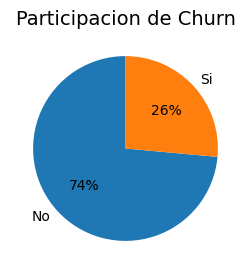

In [20]:
# Participacion de Churn: 26% fuga, 74% permanece
plt.figure(figsize=(4, 3))
plt.pie(df['Churn'].value_counts(), labels=['No','Si'], autopct='%1.0f%%', startangle=90)
plt.title('Participacion de Churn', fontsize=14)
plt.show()

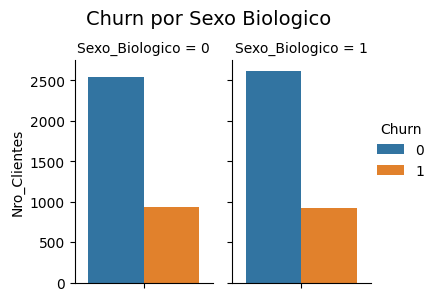

In [21]:
# Churn por Sexo: se mantiene la distribucion en ambos sexos
df2 = df.groupby(['Churn', 'Sexo_Biologico'])['Churn'].count()
df2 = df2.reset_index(name='Nro_Clientes')

ax = sns.catplot(
        data=df2, hue="Churn", y="Nro_Clientes", col="Sexo_Biologico",
        kind="bar", height=2.8, aspect=.7
     )

ax.fig.suptitle("Churn por Sexo Biologico", y=1.06, fontsize=14)
plt.show()

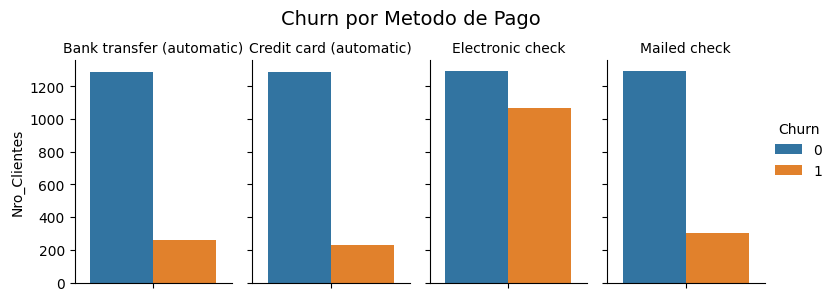

In [22]:
# Churn por Metodo de pago: el cheque electronico tiene mayor fuga que los otros tipos de pago
df2 = df.groupby(['Churn', 'Metodo_Pago'])['Churn'].count()
df2 = df2.reset_index(name='Nro_Clientes')

ax = sns.catplot(
        data=df2, hue="Churn", y="Nro_Clientes", col="Metodo_Pago",
        kind="bar", height=2.8, aspect=.7
     )

ax.set_titles(col_template="{col_name}", fontdict={'fontsize': 11})
ax.fig.suptitle("Churn por Metodo de Pago", y=1.06, fontsize=14)
plt.show()

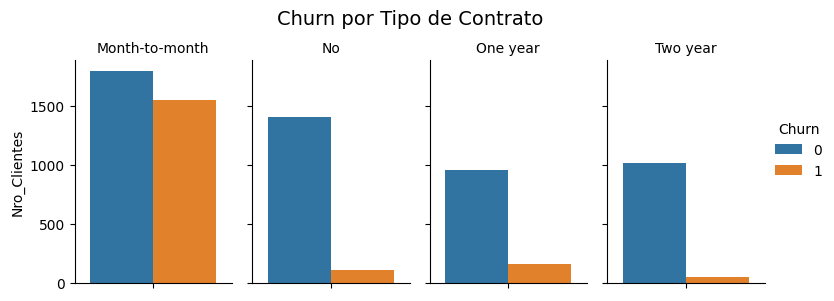

In [23]:
# Churn por Tipo de contrato: el contrato mensual tiene mayor fuga que los otros tipos de contrato
df2 = df.groupby(['Churn', 'Tipo_Contrato'])['Churn'].count()
df2 = df2.reset_index(name='Nro_Clientes')

ax = sns.catplot(
        data=df2, hue="Churn", y="Nro_Clientes", col="Tipo_Contrato",
        kind="bar", height=2.8, aspect=.7,
     )

ax.set_titles(col_template="{col_name}", fontdict={'fontsize': 11})
ax.fig.suptitle("Churn por Tipo de Contrato", y=1.06, fontsize=14)
plt.show()

/tmp/ipython-input-3637624905.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=10, rotation=45, ha='right')


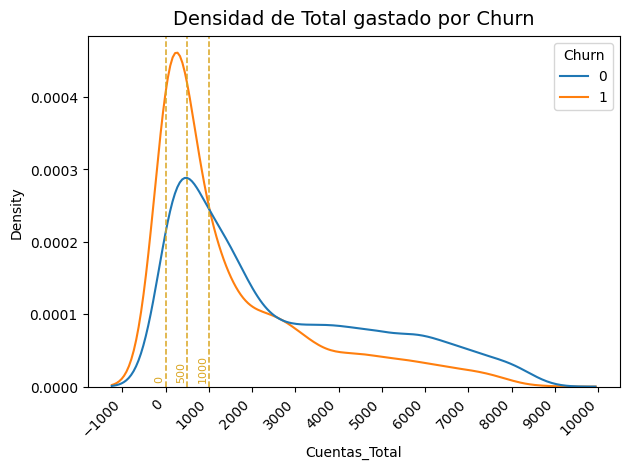

In [24]:
# Distribucion de Total gastado por Churn:
# -Clientes fugados y que permanecen tienen distribucion semejante:
#   -Alta concentracion de clientes con gastos bajos
#   -A medida que aumenta el gasto disminuye la cantidad de clientes
ax = sns.kdeplot(data=df, x="Cuentas_Total", hue="Churn", common_norm=False)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1000))
ax.set_xticklabels(ax.get_xticklabels(), fontsize=10, rotation=45, ha='right')
plt.axvline(x=0, linewidth=1.1, color='goldenrod', linestyle='--', label="0")
plt.axvline(x=500, linewidth=1.1, color='goldenrod', linestyle='--')
plt.axvline(x=1000, linewidth=1.1, color='goldenrod', linestyle='--')
plt.text(-20, 9E-6, '0', fontsize=8, color='goldenrod', ha='right', rotation=90)
plt.text(480, 9E-6, '500', fontsize=8, color='goldenrod', ha='right', rotation=90)
plt.text(980, 9E-6, '1000', fontsize=8, color='goldenrod', ha='right', rotation=90)
plt.title("Densidad de Total gastado por Churn", y=1.01, fontsize=14)
plt.tight_layout()
plt.show()

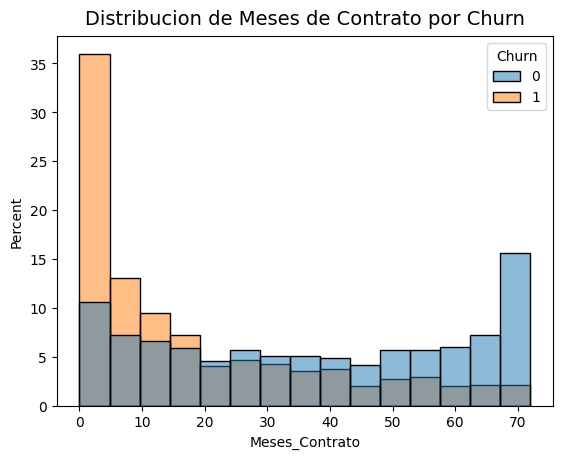

In [25]:
# Distribucion de Meses de Contrato por Churn:
# -Los clientes que fugan tienen menos meses de contrato
# -A medida que aumentan los meses de contrato mas clientes permanecen
anchobin = ancho_bin(df, 'Meses_Contrato')

sns.histplot(
    data=df, x="Meses_Contrato", hue="Churn",
    stat="percent", binwidth=anchobin, common_norm=False
)

plt.title("Distribucion de Meses de Contrato por Churn", y=1.01, fontsize=14)
plt.show()

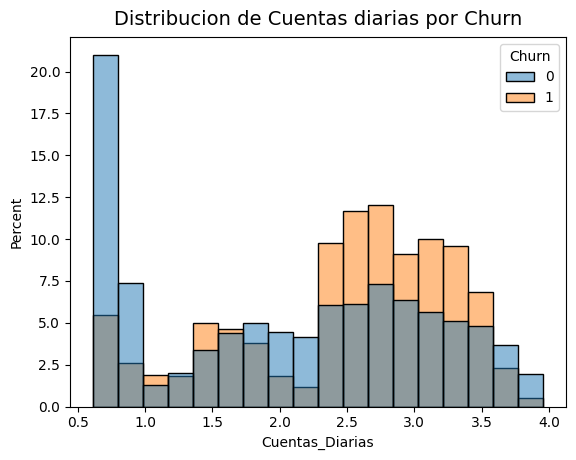

In [29]:
# Distribucion de Gasto diario
anchobin = ancho_bin(df, 'Cuentas_Diarias')

sns.histplot(
    data=df, x="Cuentas_Diarias", hue="Churn",
    stat="percent", binwidth=anchobin, common_norm=False
)

plt.title("Distribucion de Cuentas diarias por Churn", y=1.01, fontsize=14)
plt.show()

In [34]:
df.groupby('Churn')['Cuentas_Diarias'].median().round(1)

,Cuentas_Diarias
Churn,
0,2.2
1,2.7


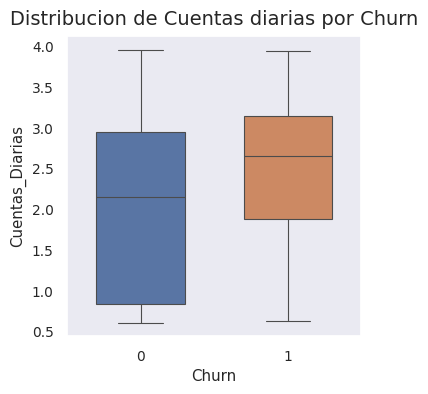

In [28]:
# Distribucion de Cuentas diarias por Churn:
# -Los clientes que permanecen están más dispersos que los clientes fugados
# -Los clientes fugados tienen asimetria negativa: la mayoria de los montos diarios son altos
# -Los clientes fugados tienen mediana mas alta:
#   -El 50% de clientes fugados tienen montos diarios > 2.7, mientras los clientes que permanecen > 2.2
sns.set(rc={"figure.figsize":(3.8, 3.9)}, font_scale=0.9)

ax = sns.boxplot(
        data=df, x='Churn', y='Cuentas_Diarias', hue='Churn',
        width=.6, linewidth=.8
     )

plt.title("Distribucion de Cuentas diarias por Churn",  y=1.01, fontsize=14)
ax.legend().set_visible(False)
ax.grid(False)
plt.show()

#📄Informe final